# План:
- оценить баланс классов по кодам
- на базовой модели найти порог необходимого и достаточного количества примеров по одному заказу
- подготовить три датасета с помощью разных методов векторизации текста
- оценить работу разных алгоритмов на разных датасетов, выбрать решение с наилучшей метрикой
- провести базовый поиск гиперпараметров для отобранного решения

# Libs

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import gc
import numpy as np
import pickle 

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from tqdm import tqdm

# models
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [ ]:
# %%time
# !python3 data-preprocessing.py

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maximmezhov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Предварительный анализ баланса классов

In [2]:
data = pd.read_csv('data/processed/processed-dataframe.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267588 entries, 0 to 267587
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   clear-description  267583 non-null  object 
 1   code               267588 non-null  float64
 2   description        267588 non-null  object 
dtypes: float64(1), object(2)
memory usage: 6.1+ MB


In [3]:
data.head()

,clear-description,code,description
0,парацетамол таблетка ячейковый контурный карто...,9300.1,"Парацетамол таблетки 500 мг 10 шт., упаковки я..."
1,перезаряжать литий ионный батарея торговый мар...,3482.2,Перезаряжаемая литий-ионная батарея торговой м...
2,перезаряжать литий ионный батарея торговый мар...,3482.2,Перезаряжаемая литий-ионная батарея торговой м...
3,аппарат вакуумный лазерный терапия стоматологи...,9444.4,Аппарат вакуумно-лазерной терапии стоматологич...
4,блок оконный балконный дверной алюминиевый про...,5270.1,Блоки оконные и балконные дверные из алюминиев...


In [4]:
# добавим столбец, который из float типа сделам int - это будет целевая переменная
data['target'] = data.code * 10
data.target = data.target.astype(int)
data.dtypes

clear-description     object
code                 float64
description           object
target                 int64
dtype: object

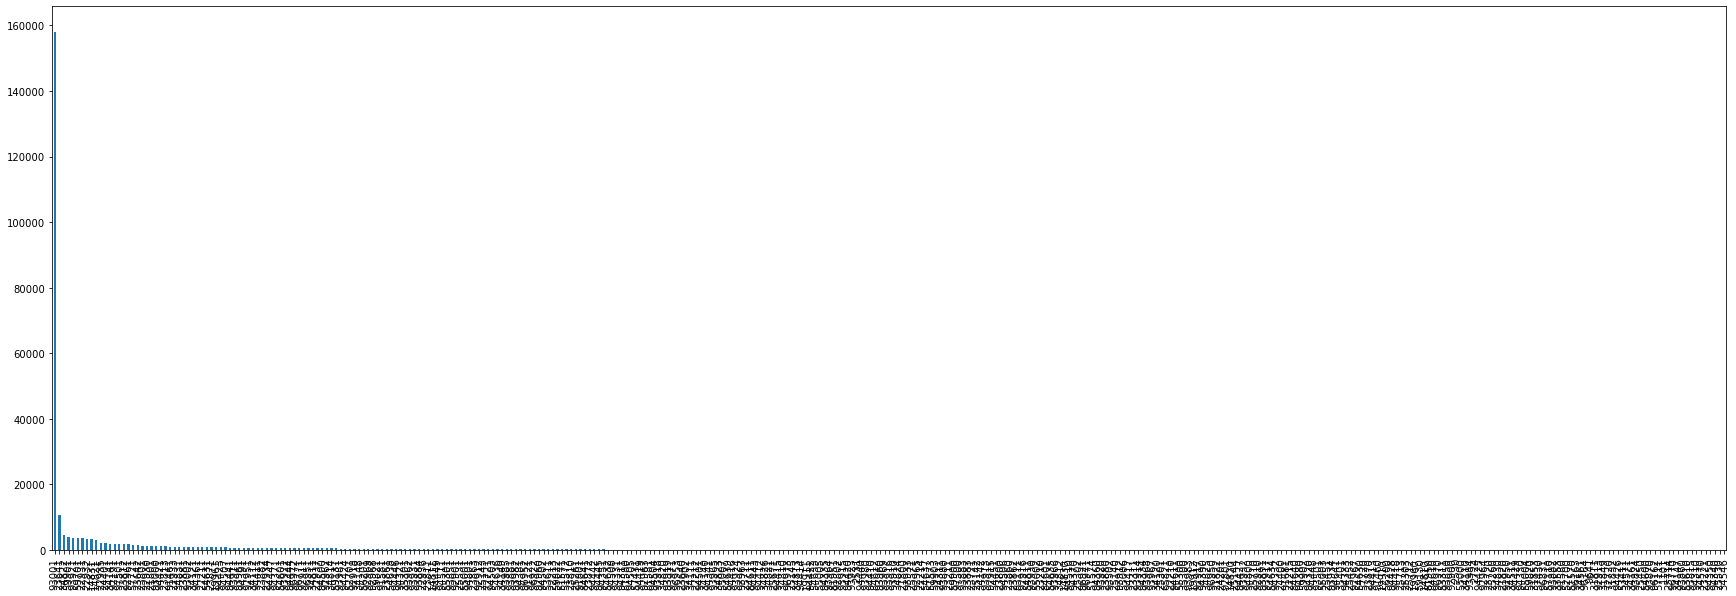

In [5]:
fig = plt.subplots(figsize=(30,10))
data.target.value_counts().plot(kind='bar');

> видим сильный дисбаланс классов

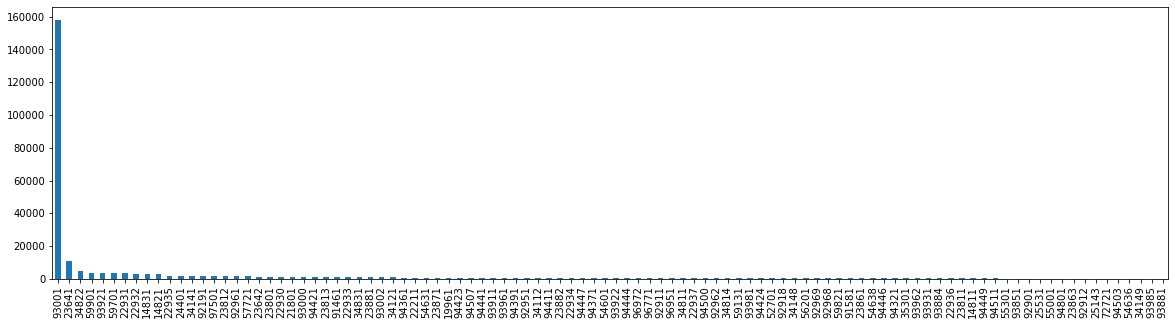

In [6]:
fig = plt.subplots(figsize=(20,5))
data.target.value_counts()[:100].plot(kind='bar');

> более всех представлен код 9300.1

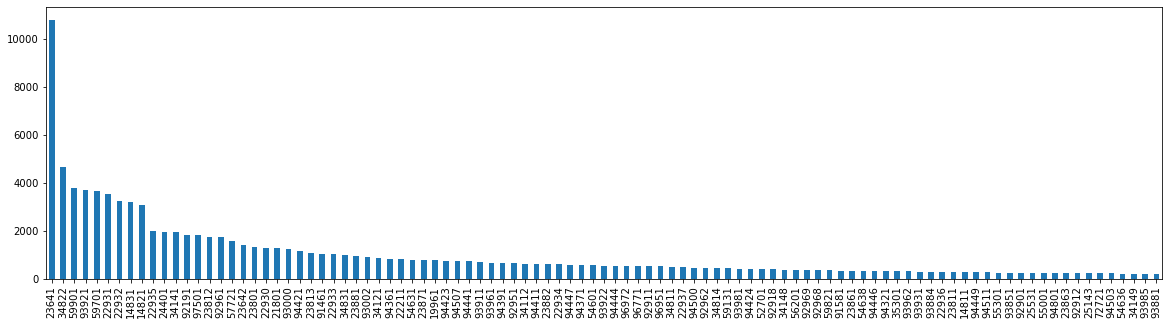

In [7]:
fig = plt.subplots(figsize=(20,5))
data.target.value_counts()[1:100].plot(kind='bar');

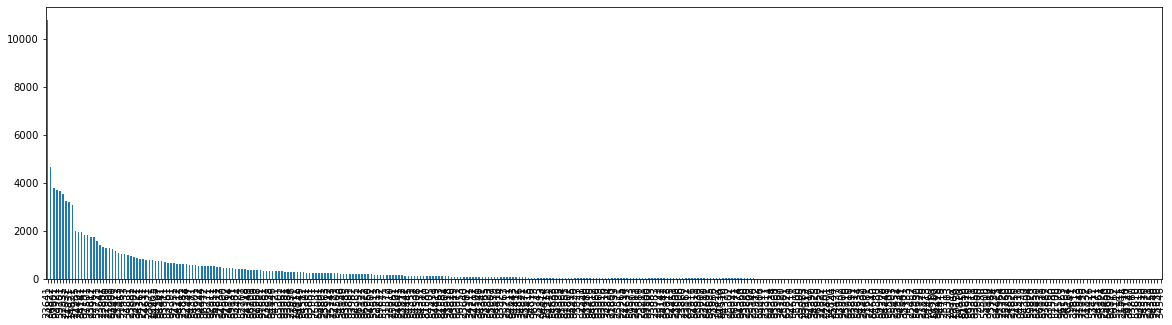

In [8]:
fig = plt.subplots(figsize=(20,5))
data.target.value_counts()[1:].plot(kind='bar');

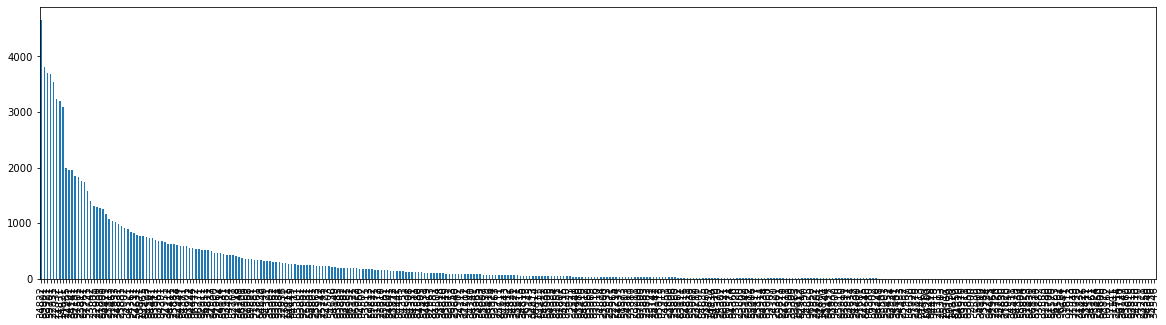

In [9]:
fig = plt.subplots(figsize=(20,5))
data.target.value_counts()[2:].plot(kind='bar');

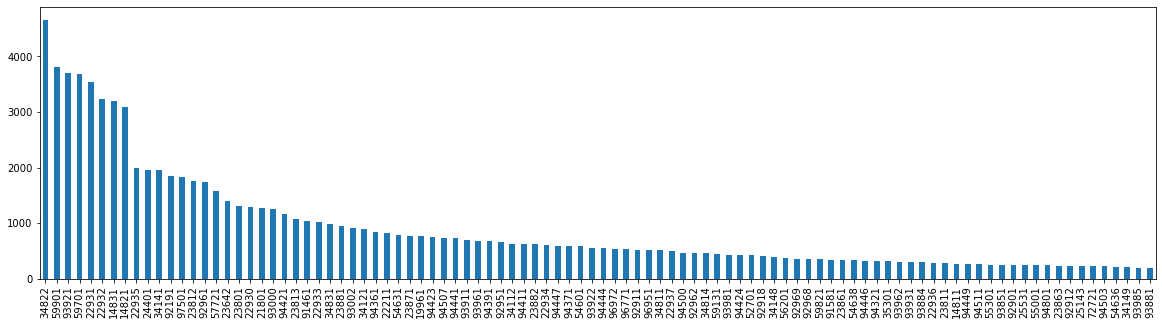

In [10]:
fig = plt.subplots(figsize=(20,5))
data.target.value_counts()[2:100].plot(kind='bar');

> как минимум по двум кодам: 9300.1 и 2364.1 сильный дисбаланс относительно количества остальных кодов с всязи с этим будет разумным применить для оценки моделей метрику f1_weighted, чтобы иметь адекватную оценку качества по всем классам

проверка на пропуски и дубликаты:

In [5]:
data.isna().sum()

clear-description    5
code                 0
description          0
target               0
dtype: int64

In [6]:
data[data['clear-description'].isna()]

,clear-description,code,description,target
249141,NaN,9146.1,,91461
250510,NaN,9695.2,,96952
258940,NaN,5982.1,,59821
259302,NaN,2388.1,,23881
259427,NaN,2293.1,,22931


In [7]:
data.dropna(inplace=True)

In [8]:
data.isna().sum()

clear-description    0
code                 0
description          0
target               0
dtype: int64

In [9]:
data.duplicated().sum()

105837

In [10]:
data[data.duplicated()].sort_values('description')

,clear-description,code,description,target
233259,бетонный смесь тяжелый бетон,2364.1,\nБетонные смеси тяжелого бетона,23641
222832,бетонный смесь тяжелый бетон,2364.1,\nБетонные смеси тяжелого бетона,23641
219578,бетонный смесь тяжелый бетон,2364.1,\nБетонные смеси тяжелого бетона,23641
219341,бетонный смесь тяжелый бетон,2364.1,\nБетонные смеси тяжелого бетона,23641
13827,вальсакор таблетка покрывать пленочный оболочк...,9300.1,"\nВальсакор Н 160 таблетки, покрытые пленочной...",93001
...,...,...,...,...
238700,шрот соевый кормовой тостированный,9146.1,шрот соевый кормовой тостированный,91461
249752,шрот соевый кормовой тостированный,9146.1,шрот соевый кормовой тостированный,91461
195015,щетка зубной взрослый,9677.1,щетки зубные для взрослых:,96771
236863,экструдат соевый кормовой,9146.1,экструдат соевый кормовой,91461


In [11]:
print('доля полных дубликатов в данных =', (100*data.duplicated().sum()/len(data)).round(2), '%')

доля полных дубликатов в данных = 39.55 %


> как видим есть полные дубликаты и причём достаточно много, почти 40%, но ничего не остаётся как удалить их, т.к. это негативно скажется на адекватности модели

In [12]:
data.shape

(267583, 4)

In [13]:
data.drop(data[data.duplicated()].index)

,clear-description,code,description,target
0,парацетамол таблетка ячейковый контурный карто...,9300.1,"Парацетамол таблетки 500 мг 10 шт., упаковки я...",93001
1,перезаряжать литий ионный батарея торговый мар...,3482.2,Перезаряжаемая литий-ионная батарея торговой м...,34822
2,перезаряжать литий ионный батарея торговый мар...,3482.2,Перезаряжаемая литий-ионная батарея торговой м...,34822
3,аппарат вакуумный лазерный терапия стоматологи...,9444.4,Аппарат вакуумно-лазерной терапии стоматологич...,94444
4,блок оконный балконный дверной алюминиевый про...,5270.1,Блоки оконные и балконные дверные из алюминиев...,52701
...,...,...,...,...
267580,формибак жидкий кормовой смесь снижение уровен...,9750.1,Формибак жидкий - кормовая смесь для снижения ...,97501
267581,котелок туристический овальный объем литр корр...,1482.1,"Котелки туристические овальные, объемом 1.7 ли...",14821
267582,посуда столовая кухонный керамический взрослый,5990.1,Посуда столовая и кухонная керамическая для вз...,59901
267583,выключатель вакуумный вр номинальный напряжени...,3414.8,"Выключатели вакуумные серии ВР1, на номинально...",34148


In [14]:
data.drop(data[data.duplicated()].index, inplace=True)

In [15]:
data.shape

(161746, 4)

# Подбор порога необходимого и достаточного количества примеров на класс
В качестве базовой модели возьмём RidgeClassifier, т.к. на практике в аналогичных задачах он показал себя хорошо и в качестве векторизатора возём if-idf, т.к. данный метод позволяет хорошо разделять докуметы, отсекая слова, часто встречающиеся во всех примерах

In [16]:
baseline = RidgeClassifier()
vectoriser = TfidfVectorizer()

In [17]:
data.head()

,clear-description,code,description,target
0,парацетамол таблетка ячейковый контурный карто...,9300.1,"Парацетамол таблетки 500 мг 10 шт., упаковки я...",93001
1,перезаряжать литий ионный батарея торговый мар...,3482.2,Перезаряжаемая литий-ионная батарея торговой м...,34822
2,перезаряжать литий ионный батарея торговый мар...,3482.2,Перезаряжаемая литий-ионная батарея торговой м...,34822
3,аппарат вакуумный лазерный терапия стоматологи...,9444.4,Аппарат вакуумно-лазерной терапии стоматологич...,94444
4,блок оконный балконный дверной алюминиевый про...,5270.1,Блоки оконные и балконные дверные из алюминиев...,52701


In [13]:
# коды, имеющие меньше 5 примеров не будем брать в данные на обучение, т.к. невозможно будет проводить перекрёстную проверку качества модели
# tvc = data.target.value_counts()
# tvc[tvc < 5].index

In [14]:
# d2 = data.copy()

In [15]:
# for tr in tvc[tvc < 5].index.tolist():
#     data.drop(data[data.target == tr].index, inplace=True)
# d2.shape, data.shape

In [18]:
# target = data.target.values
# target[:5]

array([93001, 34822, 34822, 94444, 52701])

In [17]:
# X = vectoriser.fit_transform(data['clear-description'].values)
# X.shape

(161746, 55094)

In [29]:
# terms = vectoriser.get_feature_names_out()
# terms, len(terms)
# df = pd.DataFrame(X.toarray(), columns=terms, dtypes=np.float16)
# del X
# gc.collect()
# df.head()

array(['__', 'aa', 'aaa', ..., 'ящичный', 'ящур', 'іі'], dtype=object)

In [19]:
# df.info()

In [20]:
# df = df.astype(np.float32)

In [21]:
# del data
# del d2
# del X
# gc.collect()

In [22]:
# with open('terms_to_delete.txt', 'w') as f:
#     for t in terms:
#         f.write(t+'\n')

In [23]:
# ttd = pd.read_csv('terms_to_delete.txt')
# ttd.dropna(inplace=True)
# ttd[:5].values

In [24]:
# ttd.values.flatten().tolist()[:5]

In [25]:
# df.drop(columns=ttd.values.flatten().tolist(), axis=1, inplace=True, errors='ignore')
# df.shape

In [26]:
# df['target'] = target

In [27]:
# df.head()

In [28]:
# df.to_pickle('df.pkl')

In [19]:
data.target.value_counts()

93001    86986
23641     6623
59901     2842
22931     2742
59701     2643
         ...  
25530        1
23221        1
93815        1
23720        1
34546        1
Name: target, Length: 363, dtype: int64

In [22]:
data.to_pickle('data.pkl')

In [23]:
thresholds = [5,10,20,50,100]
results = pd.DataFrame()
vc = data.target.value_counts()

for th in tqdm(thresholds):
    df = data.copy()
    for code in vc[vc < th].index:
        df.drop(df[df.target == code].index, inplace=True)
        
    X = vectoriser.fit_transform(df['clear-description'].values)
    scores = cross_val_score(baseline, X, df['target'], scoring='f1_weighted', n_jobs=-1, cv=5)  # кросс-валидация в данном случае будет стратифицированной, что необходимо при дисбалансе классов
    results[str(th)] = scores

100%|██████████| 5/5 [16:38<00:00, 199.65s/it]


In [24]:
results

,5,10,20,50,100
0,0.834704,0.836351,0.839814,0.847903,0.856389
1,0.856001,0.857483,0.861377,0.868885,0.877771
2,0.857875,0.859560,0.863317,0.871701,0.879778
3,0.843506,0.845273,0.849658,0.857608,0.867332
4,0.837387,0.838509,0.842745,0.850410,0.860348


In [27]:
results.mean().sort_values()

5      0.845894
10     0.847435
20     0.851382
50     0.859301
100    0.868323
dtype: float64

> при примерах качество ожидаемо лучше, берём этот порог, т.к. кейсодержатель акцентировал внимание на важности близости к 100% точности модели

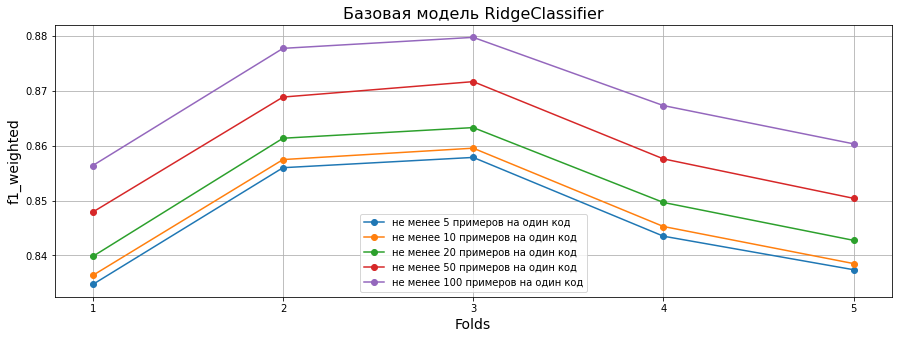

In [61]:
fig = plt.subplots(figsize=(15,5))
for p in results.columns:
    plt.plot(results[str(p)], marker='o', label=f'не менее {p} примеров на один код')
    
plt.xticks([0,1,2,3,4], [1,2,3,4,5])
plt.xlabel('Folds', fontdict={'fontsize': 14})
plt.ylabel('f1_weighted', fontdict={'fontsize': 14})
plt.title('Базовая модель RidgeClassifier', fontdict={'fontsize': 16})
plt.grid()
plt.legend()
plt.show()

# Подготовка трёх датасетов с различными алгоритмами векторизации

In [28]:
df = data.copy()
vc = df.target.value_counts()

for code in vc[vc < 100].index:
    df.drop(df[df.target == code].index, inplace=True)
    
df.shape

(156608, 4)

In [29]:
df.head()

,clear-description,code,description,target
0,парацетамол таблетка ячейковый контурный карто...,9300.1,"Парацетамол таблетки 500 мг 10 шт., упаковки я...",93001
1,перезаряжать литий ионный батарея торговый мар...,3482.2,Перезаряжаемая литий-ионная батарея торговой м...,34822
2,перезаряжать литий ионный батарея торговый мар...,3482.2,Перезаряжаемая литий-ионная батарея торговой м...,34822
3,аппарат вакуумный лазерный терапия стоматологи...,9444.4,Аппарат вакуумно-лазерной терапии стоматологич...,94444
4,блок оконный балконный дверной алюминиевый про...,5270.1,Блоки оконные и балконные дверные из алюминиев...,52701


In [44]:
df.to_pickle('data/prod_df.pkl')

In [45]:
df.to_csv('data/prod_df.csv', index=False)

`clear-description` - очищенный текст, идёт на векторизацию  
`target` - преобразованный код товара, обратное преобразование делением на 10

In [30]:
ttd = pd.read_csv('terms_to_delete.txt')
ttd.dropna(inplace=True)
terms_to_delete = ttd.values.flatten().tolist()

In [34]:
# TF-IDF
tfidf = TfidfVectorizer(stop_words=terms_to_delete).fit(df['clear-description'])
X_tfidf = tfidf.transform(df['clear-description'])

In [35]:
X_tfidf.shape

(156608, 26748)

In [38]:
# Bigramms
bigram = CountVectorizer(stop_words=terms_to_delete, ngram_range=(2,2)).fit(df['clear-description'])
X_bigram = bigram.transform(df['clear-description'])
X_bigram.shape

(156608, 183517)

In [39]:
# Simple count
cnt = CountVectorizer(stop_words=terms_to_delete).fit(df['clear-description'])
X_cnt = cnt.transform(df['clear-description'])
X_cnt.shape

(156608, 26748)

In [42]:
# save datasets
with open('data/X_tfidf.pkl', 'wb') as f:
    pickle.dump(X_tfidf, f)
with open('data/X_bigram.pkl', 'wb') as f:
    pickle.dump(X_bigram, f)
with open('data/X_cnt.pkl', 'wb') as f:
    pickle.dump(X_cnt, f)

In [43]:
# save vectorizers
with open('data/tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
with open('data/bigram.pkl', 'wb') as f:
    pickle.dump(bigram, f)
with open('data/cnt.pkl', 'wb') as f:
    pickle.dump(cnt, f)

> таким образом, подготовлены три датасета с разными подхдодами к векторизации текста, всё сохранено, в том числе итоговый датафрейм с удалёнными заказами, которые представлены менее чем 100 примерами

# Оценка работы базовой модели на разных датасетах
По итогу выберем один с лучшей метрикой

In [2]:
with open('data/X_tfidf.pkl', 'rb') as f:
    X_tfidf = pickle.load(f)
with open('data/X_bigram.pkl', 'rb') as f:
    X_bigram = pickle.load(f)
with open('data/X_cnt.pkl', 'rb') as f:
    X_cnt = pickle.load(f)
    
with open('data/prod_df.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
baseline = RidgeClassifier()
models_raiting = pd.DataFrame()

for i,X in enumerate([X_tfidf, X_bigram, X_cnt]):
    print('dataset #', i+1)
    models_score = []
    scores = cross_val_score(baseline, X, df['target'], scoring='f1_weighted', n_jobs=-1, cv=5)  # кросс-валидация в данном случае будет стратифицированной, что необходимо при дисбалансе классов
    models_raiting[str(i)] = scores
    
models_raiting.rename(mapper={'0':'X_tfidf','1':'X_bigram','2':'X_cnt'}, inplace=True)
models_raiting.sort_values(['X_tfidf', 'X_bigram', 'X_cnt'], inplace=True)
models_raiting 

dataset # 1
dataset # 2
dataset # 3


KeyError: 'X_tfidf'

In [8]:
models_raiting.rename(columns={'0':'X_tfidf','1':'X_bigram','2':'X_cnt'}, inplace=True)
# models_raiting.sort_values(['X_tfidf', 'X_bigram', 'X_cnt'], inplace=True)
models_raiting   

,X_tfidf,X_bigram,X_cnt
0,0.869920,0.827598,0.834572
1,0.878576,0.867502,0.873041
2,0.881503,0.863696,0.873685
3,0.869232,0.847044,0.860416
4,0.861603,0.839396,0.852467


In [9]:
models_raiting.mean().sort_values()

X_bigram    0.849047
X_cnt       0.858836
X_tfidf     0.872167
dtype: float64

> выбираем датасет `Х_tfidf`, т.к. на нём получаем лучшее качество

# Oценить работу разных алгоритмов, выбрать решение с наилучшей метрикой

In [10]:
models = {
    'RidgeClassifier': RidgeClassifier(),
    'LogisticRegression': LogisticRegression(),
    'LinearSVC': LinearSVC(),
    'LGBMClassifier': LGBMClassifier(),
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'MLPClassifier': MLPClassifier()
}

In [11]:
df.head()

,clear-description,code,description,target
0,парацетамол таблетка ячейковый контурный карто...,9300.1,"Парацетамол таблетки 500 мг 10 шт., упаковки я...",93001
1,перезаряжать литий ионный батарея торговый мар...,3482.2,Перезаряжаемая литий-ионная батарея торговой м...,34822
2,перезаряжать литий ионный батарея торговый мар...,3482.2,Перезаряжаемая литий-ионная батарея торговой м...,34822
3,аппарат вакуумный лазерный терапия стоматологи...,9444.4,Аппарат вакуумно-лазерной терапии стоматологич...,94444
4,блок оконный балконный дверной алюминиевый про...,5270.1,Блоки оконные и балконные дверные из алюминиев...,52701


In [12]:
models_raiting = pd.DataFrame()

for model in models.items():
    model_score = []
    print(model[0], 'estimation...')
    scores = cross_val_score(model[1], X_tfidf, df['target'], scoring='f1_weighted', n_jobs=-1, cv=5)  # кросс-валидация в данном случае будет стратифицированной, что необходимо при дисбалансе классов
    models_raiting[model[0]] = scores
    
models_raiting

RidgeClassifier estimation...
LogisticRegression estimation...


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

LinearSVC estimation...
LGBMClassifier estimation...
ExtraTreesClassifier estimation...
RandomForestClassifier estimation...
GradientBoostingClassifier estimation...


KeyboardInterrupt: 

In [13]:
models_raiting

,RidgeClassifier,LogisticRegression,LinearSVC,LGBMClassifier,ExtraTreesClassifier,RandomForestClassifier
0,0.869920,0.847405,0.845923,0.390312,0.840015,0.842502
1,0.878576,0.881345,0.886340,0.187687,0.882256,0.885107
2,0.881503,0.879866,0.888177,0.248019,0.883328,0.884705
3,0.869232,0.867998,0.874941,0.509216,0.870020,0.870272
4,0.861603,0.860589,0.870212,0.428183,0.863716,0.864790


> не все алгоритмы успели отработать, пришлось остановить вычисления, что успелось посчитаться, из того и выбираем

In [15]:
models_raiting.mean().sort_values(ascending=False)

LinearSVC                 0.873119
RidgeClassifier           0.872167
RandomForestClassifier    0.869475
ExtraTreesClassifier      0.867867
LogisticRegression        0.867441
LGBMClassifier            0.352684
dtype: float64

> выбираем модель `LinearSVC`, т.к. она имеет наилучшее качество

# Провести базовый поиск гиперпараметров для отобранного решения
Пока откладываю, т.к. необходимо заниматься приложением

# Обучение модели для дальнейшего использования в приложении
На третьем фолде было лучшее качество на базовой модели, такое же разбиение и возьмём для обучения

In [20]:
spliter.split(X_tfidf, df['target'])

<generator object _BaseKFold.split at 0x16be90040>

In [24]:
spliter = StratifiedKFold(n_splits=5)
train_index, test_index = next(spliter.split(X_tfidf, df['target']), 2)
train_index, test_index

(array([   847,    848,    849, ..., 156605, 156606, 156607]),
 array([     0,      1,      2, ..., 125926, 126797, 126894]))

In [35]:
df

,clear-description,code,description,target
0,парацетамол таблетка ячейковый контурный карто...,9300.1,"Парацетамол таблетки 500 мг 10 шт., упаковки я...",93001
1,перезаряжать литий ионный батарея торговый мар...,3482.2,Перезаряжаемая литий-ионная батарея торговой м...,34822
2,перезаряжать литий ионный батарея торговый мар...,3482.2,Перезаряжаемая литий-ионная батарея торговой м...,34822
3,аппарат вакуумный лазерный терапия стоматологи...,9444.4,Аппарат вакуумно-лазерной терапии стоматологич...,94444
4,блок оконный балконный дверной алюминиевый про...,5270.1,Блоки оконные и балконные дверные из алюминиев...,52701
...,...,...,...,...
267580,формибак жидкий кормовой смесь снижение уровен...,9750.1,Формибак жидкий - кормовая смесь для снижения ...,97501
267581,котелок туристический овальный объем литр корр...,1482.1,"Котелки туристические овальные, объемом 1.7 ли...",14821
267582,посуда столовая кухонный керамический взрослый,5990.1,Посуда столовая и кухонная керамическая для вз...,59901
267583,выключатель вакуумный вр номинальный напряжени...,3414.8,"Выключатели вакуумные серии ВР1, на номинально...",34148


In [43]:
df.iloc[train_index, :]['target']

1509      93851
1512      93851
1513      93851
1515      93851
1516      93851
          ...  
267580    97501
267581    14821
267582    59901
267583    34148
267587    96951
Name: target, Length: 125286, dtype: int64

In [45]:
prod_model = LinearSVC()

prod_model.fit(X_tfidf[train_index].toarray(), df.iloc[train_index, :]['target'])

LinearSVC()

In [46]:
with open('models/LinearSVC.pkl', 'wb') as f:
    pickle.dump(prod_model, f)

> модель обучена и готава к интегарции в приложение

In [48]:
with open('data/tfidf.pkl', 'rb') as f:
    tfidf = pickle.load(f)
tfidf.get_feature_names_out()

array(['arj', 'castto', 'dallo', ..., 'ящичный', 'ящур', 'іі'],
      dtype=object)

> видно, что можно улучшать предобработку текстов, чтобы исключить ненужные слова, это может повысить качество

In [2]:
!conda list -e > requirements_conda.txt

In [3]:
!pip freeze > requirements_pip.txt